In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
import os

In [2]:
model = load_model('models/unet_no_drop.h5')

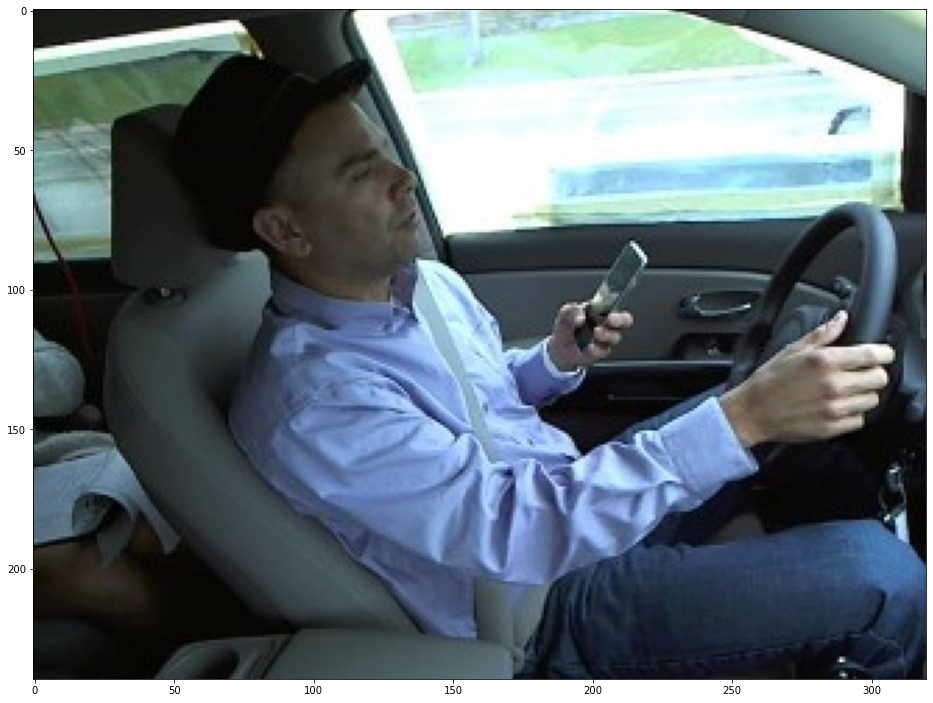

In [26]:
IMG_PATH = 'C:/Users/USEUNG/Desktop/deep_learning_project/imgs/train/c3/img_42353.jpg'

img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 16))
plt.imshow(img_ori)

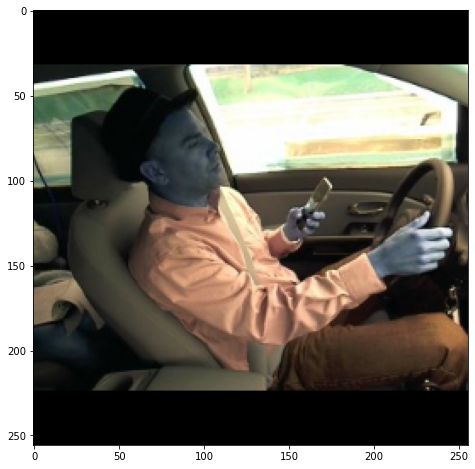

In [27]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

def preprocess(img):
    im = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / IMG_HEIGHT
        new_width = int(img.shape[1] / scale)
        diff = (IMG_WIDTH - new_width) // 2
        img = cv2.resize(img, (new_width, IMG_HEIGHT))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (IMG_HEIGHT - new_height) // 2
        img = cv2.resize(img, (IMG_WIDTH, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

img = preprocess(img)

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [28]:
input_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.

pred = model.predict(input_img)

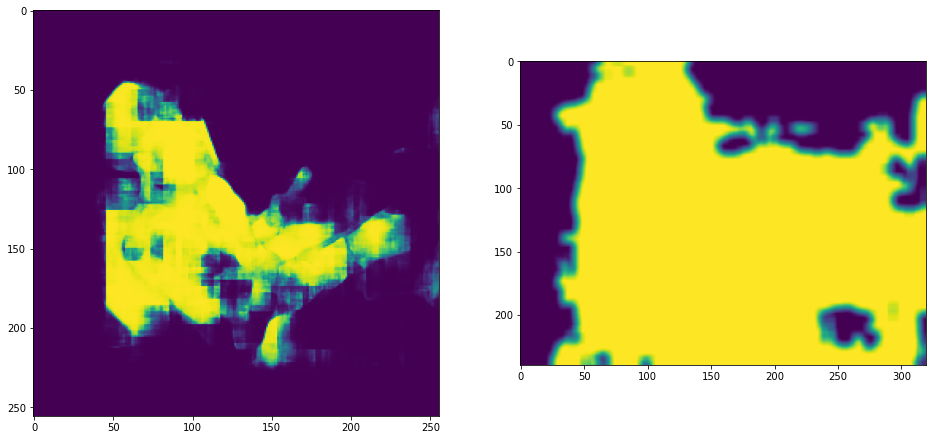

In [29]:
THRESHOLD = 1e-5
EROSION = 1

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]
    
    mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
    max_size = max(h, w)
    result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

    if h >= w:
        diff = (max_size - w) // 2
        if diff > 0:
            result_mask = result_mask[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        if diff > 0:
            result_mask = result_mask[diff:-diff, :]
        
    result_mask = cv2.resize(result_mask, dsize=(w, h))
    
    # fill holes
#     cv2.floodFill(result_mask, mask=np.zeros((h+2, w+2), np.uint8), seedPoint=(0, 0), newVal=255)
#     result_mask = cv2.bitwise_not(result_mask)
    result_mask *= 255

#     # erode image
#     element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*EROSION + 1, 2*EROSION+1), (EROSION, EROSION))
#     result_mask = cv2.erode(result_mask, element)

    # smoothen edges
    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)
    
    return result_mask

mask = postprocess(img_ori, pred)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)

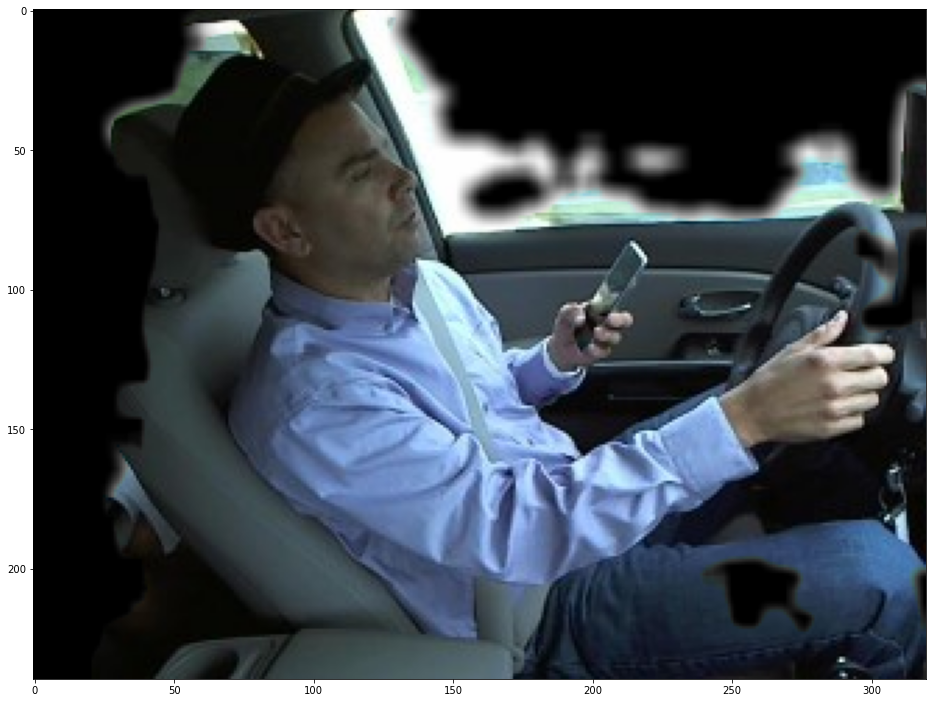

In [30]:
converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

result_img = cv2.subtract(converted_mask, img_ori)
result_img = cv2.subtract(converted_mask, result_img)

plt.figure(figsize=(16, 16))
plt.imshow(result_img)

# Aug Code

In [8]:
THRESHOLD = 1e-5
EROSION = 1
for i in range(10):
    filename = glob.glob('C:/Users/USEUNG/Desktop/deep_learning_project/imgs3/train/c%d/*.jpg' % i)
    cnt = 0
    
    for j in range(len(filename)):
        img = cv2.imread(filename[j], cv2.IMREAD_COLOR)
        img_ori = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        img = preprocess(img)
        input_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.
        pred = model.predict(input_img)
        
        def postprocess(img_ori, pred):
            h, w = img_ori.shape[:2]

            mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
            max_size = max(h, w)
            result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

            if h >= w:
                diff = (max_size - w) // 2
                if diff > 0:
                    result_mask = result_mask[:, diff:-diff]
            else:
                diff = (max_size - h) // 2
                if diff > 0:
                    result_mask = result_mask[diff:-diff, :]

            result_mask = cv2.resize(result_mask, dsize=(w, h))

            # fill holes
        #     cv2.floodFill(result_mask, mask=np.zeros((h+2, w+2), np.uint8), seedPoint=(0, 0), newVal=255)
        #     result_mask = cv2.bitwise_not(result_mask)
            result_mask *= 255

        #     # erode image
        #     element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*EROSION + 1, 2*EROSION+1), (EROSION, EROSION))
        #     result_mask = cv2.erode(result_mask, element)

            # smoothen edges
            result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)

            return result_mask

        mask = postprocess(img_ori, pred)

        # plt.figure(figsize=(16, 16))
        # plt.subplot(1, 2, 1)
        # plt.imshow(pred[0, :, :, 1])
        # plt.subplot(1, 2, 2)
        # plt.imshow(mask)

        
        converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        result_img = cv2.subtract(converted_mask, img_ori)
        result_img = cv2.subtract(converted_mask, result_img)

        # plt.figure(figsize=(16, 16))
        # plt.imshow(result_img)

        result_img = cv2.resize(result_img,(320,240))
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('C:/Users/USEUNG/Desktop/deep_learning_project/imgs3/train/c%d/aimg_%d.jpg' % (i, cnt), result_img)
        cnt+= 1
        
    print('Folder C%d Finish!!' % i)

Folder C0 Finish!!
Folder C1 Finish!!
Folder C2 Finish!!
Folder C3 Finish!!
Folder C4 Finish!!
Folder C5 Finish!!
Folder C6 Finish!!
Folder C7 Finish!!
Folder C8 Finish!!
Folder C9 Finish!!
